# Multi-Class Classification

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import numpy as np
from matplotlib.colors import LinearSegmentedColormap # For custom color map

## Data generator

In [2]:
# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=2, # X features
    centers=4, # y labels 
    cluster_std=1.6, # Group spreadness (try changing this to 1.0, the default)
    random_state=42)

In [3]:
X_blob.shape, y_blob.shape

((1000, 2), (1000,))

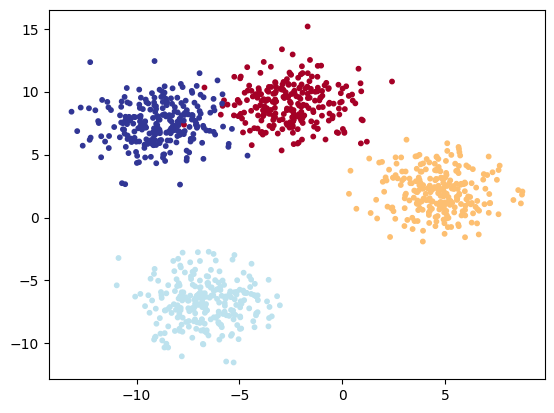

In [4]:
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu, s=10)

In [5]:
"""
The data generated previously is in Numpy array, the we convert to torch tensor
y0 is lLABEL !, so it must be integer and it is looks like:
Cat → 0
Dog → 1
Rabbit → 2
""" 
x0 = torch.from_numpy(X_blob).type(torch.float)
y0 = torch.from_numpy(y_blob).type(torch.long) # torch.long = torch.int64

x_train, x_test, y_train, y_test = train_test_split(x0,
                                                   y0,
                                                   test_size=0.2,
                                                   random_state=42)

x_train[:5], y_train[:5]

(tensor([[ 5.0672,  3.3966],
         [-2.6326,  9.5601],
         [-8.6337, -9.1842],
         [-5.9693, -4.2747],
         [-3.3950,  7.0977]]),
 tensor([1, 0, 2, 2, 0]))

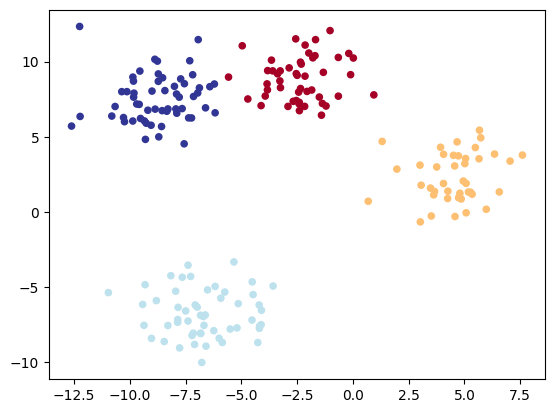

In [24]:
# Plot test
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=plt.cm.RdYlBu, s=20)

## Model Architecture

In [6]:
# We no need to use ReLu, because we can draw straight line to separate all classes. See Graph above
class MultiClassification(nn.Module):
    def __init__(self, in_feature, out_feature, neuron=8):
        super().__init__()
        self.layer1 = nn.Linear(in_feature, neuron)
        self.layer2 = nn.Linear(neuron, neuron)
        self.layer3 = nn.Linear(neuron, out_feature)
        # self.relu = nn.ReLU() # <- add in ReLU activation function
        
    def forward(self, x):
        x = self.layer1(x)
        # x = self.relu(x)
        x = self.layer2(x)
        # x = self.relu(x)
        x = self.layer3(x)
        return x

### Model initalization

In [7]:
model = MultiClassification(in_feature=2, # We have 2 column (feature) in X_blob
                            out_feature=4)  

loss_fn = nn.CrossEntropyLoss() # For multi-class classification, it has softmax built-in internally
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


In [8]:
model

MultiClassification(
  (layer1): Linear(in_features=2, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=4, bias=True)
)

In [9]:
# Perform a single forward pass on the data
model(x_train)[:5]

tensor([[ 0.2092,  0.6486,  0.3113, -0.0027],
        [ 0.8678,  1.1474, -0.3036, -1.1385],
        [-0.7336, -0.2864, -0.7694, -0.4499],
        [-0.3291,  0.0861, -0.5607, -0.5275],
        [ 0.6571,  0.9590, -0.3628, -1.0456]], grad_fn=<SliceBackward0>)

In [10]:
# How many elements in a single prediction sample?
model(x_train)[0].shape

torch.Size([4])

### Training Process

In [11]:
torch.manual_seed(42)

num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    y_logits = model(x_train)
    
    # Computer loss ( predicted label, true label)
    loss = loss_fn(y_logits, y_train)
    train_losses.append(loss.item())

    # Optimizer zero gradient
    optimizer.zero_grad()

    # BAckward pass
    loss.backward()

    # Optimizer step
    optimizer.step()

    # TESTING
    model.eval()

    with torch.inference_mode():
        test_logit = model(x_test)
        test_preds = torch.round(torch.sigmoid(test_logit))
        test_loss = loss_fn(test_logit, y_test)
        test_losses.append(test_loss.item())
        
    if epoch % 5 == 0:
        print(f'Epoch: [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch: [1/50], Loss: 1.7428
Epoch: [6/50], Loss: 0.3267
Epoch: [11/50], Loss: 0.1948
Epoch: [16/50], Loss: 0.1380
Epoch: [21/50], Loss: 0.1080
Epoch: [26/50], Loss: 0.0901
Epoch: [31/50], Loss: 0.0784
Epoch: [36/50], Loss: 0.0703
Epoch: [41/50], Loss: 0.0645
Epoch: [46/50], Loss: 0.0601


### Training vs Losses

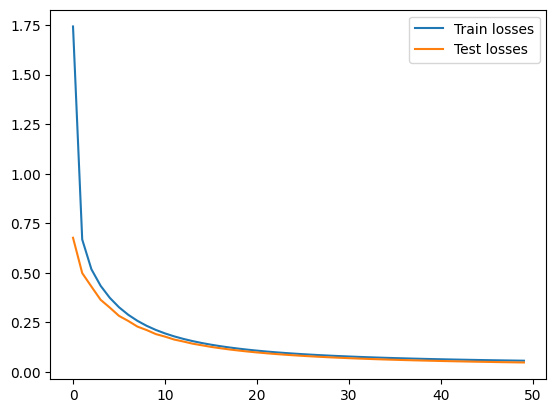

In [12]:
# Plot Train losses vs test losses
plt.plot(range(num_epochs), train_losses, label='Train losses')
plt.plot(range(num_epochs), test_losses, label='Test losses')
plt.legend()

## Evaluation

In [13]:
"""
We can see the results are in logit form. And to make evaluation, we need to convert it to what y0 (label) form.
Which is integer form.
"""
model.eval()
with torch.inference_mode():
    preds = model(x_test)

preds[:10]

tensor([[  5.9710,   9.5970,  -6.6067,  -3.3844],
        [  2.4175,  -8.0765,  -0.6442,   6.3140],
        [-10.3631, -12.2991,  10.6134,   3.2226],
        [  2.2728,   6.4306,  -3.0154,  -3.0346],
        [  9.0354,   5.2572,  -8.3871,   0.7817],
        [  2.5519, -10.3772,  -0.3600,   7.8470],
        [-10.2175,  -9.7370,  10.0535,   1.6492],
        [  6.9725,   1.4951,  -6.0412,   2.2539],
        [-11.4171, -16.7715,  12.2498,   5.6067],
        [  7.5683,   2.8298,  -6.7613,   1.6699]])

In [14]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(preds, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_test[:10]}")
# print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])


### Boundary Plot

In [15]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source 1 - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    Source 2 - https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
    """

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.figure(figsize=(5, 5))
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=2, cmap=custom_cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [16]:
# Custom color map
color1 = (8/255, 120/255, 190/255) # cool blue
color2 = (245/255, 150/255, 35/255) # warm orange
color3 = (34/255, 153/255, 84/255) # fresh green
color4 = (255/255, 182/255, 193/255) # Pastel pink
color5 = (180/255, 180/255, 180/255) # Light Grey
# Create a custom colormap using these colors
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [color1, color3, color2])

Text(0.5, 1.0, 'Test')

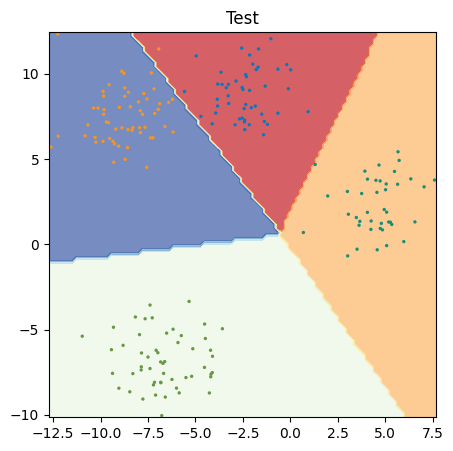

In [17]:
plot_decision_boundary(model, x_test, y_test)
plt.title("Test")

### Metric Accuracy

In [18]:
# pip install torchmetrics
from torchmetrics import Accuracy

In [19]:
# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4)

# Calculate accuracy
torchmetrics_accuracy(preds, y_test)

tensor(0.9950)